Perform clustering on FIFA 18 player performance data (PlayerAttributeData.csv) <br>
<br>
● Use both visuals and statistical methods (elbow) to identify a cluster multiplicity<br>
<br>
● Use the PlayerAttributeData.csv data to assign a label to each cluster (e.g. cluster x - average
age is young, nationality is Spanish, and wages are high)

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns; sns.set()
from scipy import stats
import pandas_profiling as pp

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn import metrics
import re


%matplotlib inline


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Load and inspect the data

In [3]:
attr = pd.read_csv("PlayerAttributeData.csv", dtype = object)
attr.head()

Unnamed: 0 Acceleration Aggression Agility Balance Ball control Composure  \
0          0           89         63      89      63           93        95   
1          1           92         48      90      95           95        96   
2          2           94         56      96      82           95        92   
3          3           88         78      86      60           91        83   
4          4           58         29      52      35           48        70   

  Crossing Curve Dribbling   ...   Reactions Short passing Shot power  \
0       85    81        91   ...          96            83         94   
1       77    89        97   ...          95            88         85   
2       75    81        96   ...          88            81         80   
3       77    86        86   ...          93            83         87   
4       15    14        30   ...          85            55         25   

  Sliding tackle Sprint speed Stamina Standing tackle Strength Vision Volleys  
0             23           91      92              31       80     85      88  
1             26           87      73              28       59     90      85  
2             33           90      78              24       53     80      83  
3             38           77      89              45       80     84      88  
4             11           61      44              10       83     70      11  

[5 rows x 36 columns]

In [4]:
attr = attr.drop(columns = ["Unnamed: 0"], axis = 1)

In [5]:
attr.isna().sum()


Acceleration          0
Aggression            0
Agility               0
Balance               0
Ball control          0
Composure             0
Crossing              0
Curve                 0
Dribbling             0
Finishing             0
Free kick accuracy    0
GK diving             0
GK handling           0
GK kicking            0
GK positioning        0
GK reflexes           0
Heading accuracy      0
ID                    0
Interceptions         0
Jumping               0
Long passing          0
Long shots            0
Marking               0
Penalties             0
Positioning           0
Reactions             0
Short passing         0
Shot power            0
Sliding tackle        0
Sprint speed          0
Stamina               0
Standing tackle       0
Strength              0
Vision                0
Volleys               0
dtype: int64

In [6]:
attr.dtypes

Acceleration          object
Aggression            object
Agility               object
Balance               object
Ball control          object
Composure             object
Crossing              object
Curve                 object
Dribbling             object
Finishing             object
Free kick accuracy    object
GK diving             object
GK handling           object
GK kicking            object
GK positioning        object
GK reflexes           object
Heading accuracy      object
ID                    object
Interceptions         object
Jumping               object
Long passing          object
Long shots            object
Marking               object
Penalties             object
Positioning           object
Reactions             object
Short passing         object
Shot power            object
Sliding tackle        object
Sprint speed          object
Stamina               object
Standing tackle       object
Strength              object
Vision                object
Volleys       

In [8]:
players = pd.read_csv("PlayerPersonalData.csv")
players.head()

Unnamed: 0  Unnamed: 0.1      ID               Name  Age  \
0           0             0   20801  Cristiano Ronaldo   32   
1           1             1  158023           L. Messi   30   
2           2             2  190871             Neymar   25   
3           3             3  176580          L. Suárez   30   
4           4             4  167495           M. Neuer   31   

                                             Photo Nationality  \
0   https://cdn.sofifa.org/48/18/players/20801.png    Portugal   
1  https://cdn.sofifa.org/48/18/players/158023.png   Argentina   
2  https://cdn.sofifa.org/48/18/players/190871.png      Brazil   
3  https://cdn.sofifa.org/48/18/players/176580.png     Uruguay   
4  https://cdn.sofifa.org/48/18/players/167495.png     Germany   

                                  Flag  Overall  Potential  \
0  https://cdn.sofifa.org/flags/38.png       94         94   
1  https://cdn.sofifa.org/flags/52.png       93         93   
2  https://cdn.sofifa.org/flags/54.png       92         94   
3  https://cdn.sofifa.org/flags/60.png       92         92   
4  https://cdn.sofifa.org/flags/21.png       92         92   

                  Club                                   Club Logo   Value  \
0       Real Madrid CF  https://cdn.sofifa.org/24/18/teams/243.png  €95.5M   
1         FC Barcelona  https://cdn.sofifa.org/24/18/teams/241.png   €105M   
2  Paris Saint-Germain   https://cdn.sofifa.org/24/18/teams/73.png   €123M   
3         FC Barcelona  https://cdn.sofifa.org/24/18/teams/241.png    €97M   
4     FC Bayern Munich   https://cdn.sofifa.org/24/18/teams/21.png    €61M   

    Wage  Special  
0  €565K     2228  
1  €565K     2154  
2  €280K     2100  
3  €510K     2291  
4  €230K     1493

In [9]:
players = players.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [10]:
players.isna().sum()

ID               0
Name             0
Age              0
Photo            0
Nationality      0
Flag             0
Overall          0
Potential        0
Club           248
Club Logo        0
Value            0
Wage             0
Special          0
dtype: int64

In [11]:
# Reorder, ID to the back

players = players[['Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'ID']]

In [12]:
players_ID = players.sort_values(by="ID")
players_ID.head()

Name  Age                                         Photo  \
4920    Luis García   36   https://cdn.sofifa.org/48/18/players/16.png   
4963   Manu Herrera   35   https://cdn.sofifa.org/48/18/players/28.png   
45          Iniesta   33   https://cdn.sofifa.org/48/18/players/41.png   
693    E. Belözoğlu   36   https://cdn.sofifa.org/48/18/players/80.png   
16121        C. Day   41  https://cdn.sofifa.org/48/18/players/591.png   

      Nationality                                 Flag  Overall  Potential  \
4920        Spain  https://cdn.sofifa.org/flags/45.png       70         70   
4963        Spain  https://cdn.sofifa.org/flags/45.png       70         70   
45          Spain  https://cdn.sofifa.org/flags/45.png       87         87   
693        Turkey  https://cdn.sofifa.org/flags/48.png       79         79   
16121     England  https://cdn.sofifa.org/flags/14.png       57         57   

                         Club                                      Club Logo  \
4920                KAS Eupen    https://cdn.sofifa.org/24/18/teams/2013.png   
4963               CA Osasuna     https://cdn.sofifa.org/24/18/teams/479.png   
45               FC Barcelona     https://cdn.sofifa.org/24/18/teams/241.png   
693    İstanbul Başakşehir FK  https://cdn.sofifa.org/24/18/teams/101014.png   
16121               Stevenage     https://cdn.sofifa.org/24/18/teams/361.png   

        Value   Wage  Special   ID  
4920    €575K    €7K     1874   16  
4963    €425K    €4K     1143   28  
45     €29.5M  €260K     2073   41  
693       €4M   €26K     2055   80  
16121    €10K    €1K      825  591

# Prepare data for clustering

## Removing + - and change dtype to int

In [15]:
reg='[+-]\d{1,3}'
attr=attr.replace(to_replace=reg, value='', regex=True)

attr = attr.astype('int64')


## Organise columns, check values, remove ID

In [17]:
attr_cols = attr.columns.tolist()
attr_cols

['Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Heading accuracy',
 'ID',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys']

In [18]:
# Bring ID to the back 

att_cols = ['Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK diving',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Heading accuracy',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys',
 'ID']

In [19]:
attr = attr[att_cols]
attr_ID = attr.sort_values(by="ID")


In [20]:
attr_ID.head()

Acceleration  Aggression  Agility  Balance  Ball control  Composure  \
4920             56          71       62       72            72         79   
4963             41          37       55       60            15         45   
45               72          58       79       84            94         89   
693              54          87       68       84            81         77   
16121            11          23       20       37            16         40   

       Crossing  Curve  Dribbling  Finishing ...   Short passing  Shot power  \
4920         68     76         69         64 ...              72          72   
4963         25     24         13         13 ...              22          25   
45           77     80         90         70 ...              92          65   
693          83     83         75         68 ...              86          79   
16121         8     14          7          8 ...              21          12   

       Sliding tackle  Sprint speed  Stamina  Standing tackle  Strength  \
4920               42            52       65               46        60   
4963               14            49       32               13        60   
45                 56            71       58               57        58   
693                64            42       61               65        65   
16121              17            12       25               11        56   

       Vision  Volleys   ID  
4920       73       68   16  
4963       24       13   28  
45         94       74   41  
693        86       69   80  
16121      23       15  591  

[5 rows x 35 columns]

In [22]:
# Create df without ID for clustering

attr_noid = attr_ID.copy()
attr_noid.pop("ID")

4920         16
4963         28
45           41
693          80
16121       591
6275        657
1587        768
10332       887
1861       1178
18         1179
9562       1210
1771       2147
1103       2196
11036      2335
870        2492
13329      2702
1524       3281
3043       3484
2224       3665
3677       3974
15946      4323
8213       4732
1036       5213
197        5479
1534       5594
692        6826
1537       7647
9858       7674
691        7763
829        7826
          ...  
15063    241160
13712    241165
2654     241166
10956    241167
10964    241168
12914    241169
12026    241171
14416    241172
8855     241175
16047    241176
16413    241177
13744    241178
8873     241179
13751    241181
14448    241183
14450    241184
13760    241185
16422    241186
15119    241187
15129    241193
16445    241200
17490    241201
14501    241202
17788    241204
17790    241206
17292    241207
17793    241213
17300    241216
17893    241218
17304    241219
Name: ID, Length: 17981,

# Default SNS clustering

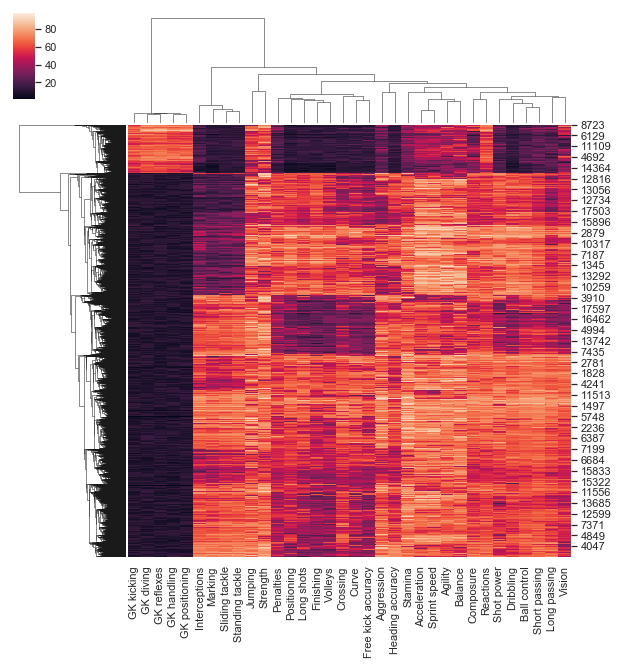

In [32]:

sns.clustermap(attr_noid)

# K Means clustering

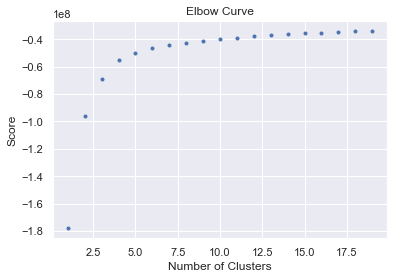

In [23]:
# Find optimal number of clusters

Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(attr_noid).score(attr_noid) for i in range(len(kmeans))]

score

plt.plot(Nc, score, ".")
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [24]:
# Perform clustering

Kmean = KMeans(n_clusters=4)
fit_4 = Kmean.fit(attr_noid)
fit_4.labels_

array([3, 1, 3, ..., 2, 2, 0])

In [25]:
# Asign labels to the column

attr_noid["CL"] = fit_4.labels_
attr_noid.head()

Acceleration  Aggression  Agility  Balance  Ball control  Composure  \
4920             56          71       62       72            72         79   
4963             41          37       55       60            15         45   
45               72          58       79       84            94         89   
693              54          87       68       84            81         77   
16121            11          23       20       37            16         40   

       Crossing  Curve  Dribbling  Finishing ...  Short passing  Shot power  \
4920         68     76         69         64 ...             72          72   
4963         25     24         13         13 ...             22          25   
45           77     80         90         70 ...             92          65   
693          83     83         75         68 ...             86          79   
16121         8     14          7          8 ...             21          12   

       Sliding tackle  Sprint speed  Stamina  Standing tackle  Strength  \
4920               42            52       65               46        60   
4963               14            49       32               13        60   
45                 56            71       58               57        58   
693                64            42       61               65        65   
16121              17            12       25               11        56   

       Vision  Volleys  CL  
4920       73       68   3  
4963       24       13   1  
45         94       74   3  
693        86       69   3  
16121      23       15   1  

[5 rows x 35 columns]

In [28]:
# Sort by cluster number for visualisation

attr_noid_sort = attr_noid.sort_values("CL")
attr_KMid = attr_noid_sort.copy()

In [29]:
plt.figure(figsize=(15,10))
sns.heatmap(attr_KMid)

# Remove correlated features and visualise again

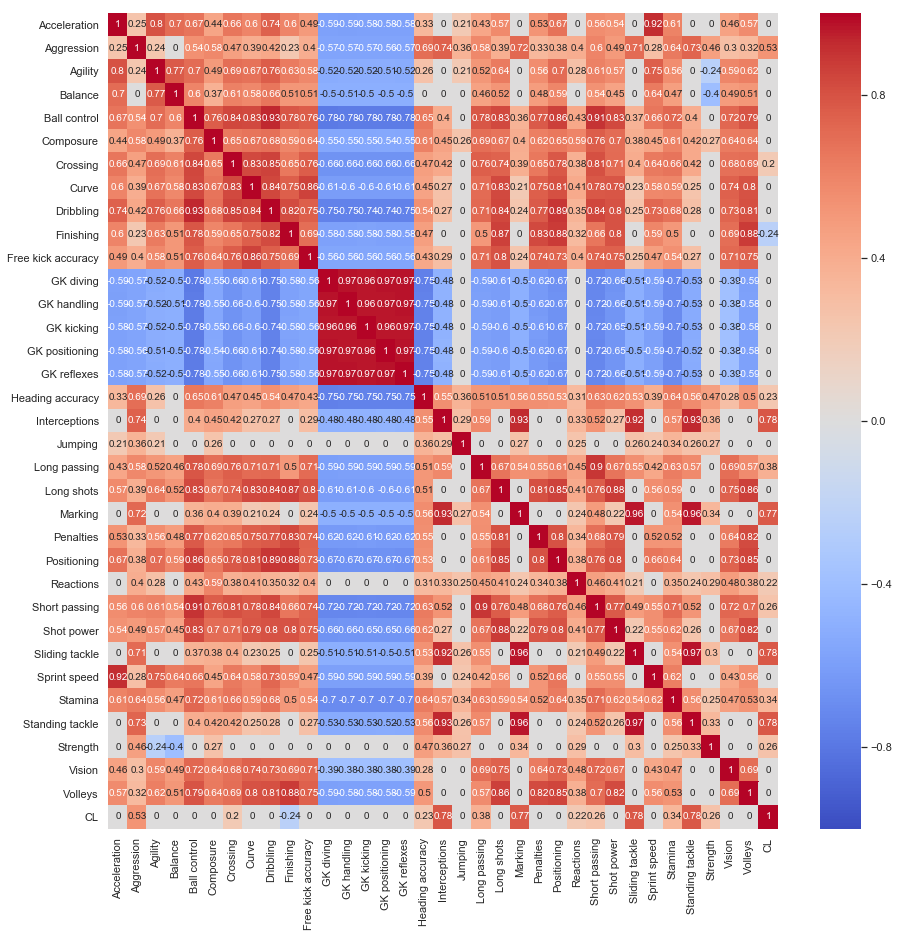

In [31]:
subjective_corr = attr_noid.corr()
subjective_corr[np.abs(subjective_corr)<.2] = 0
plt.figure(figsize=(15,15))
sns.heatmap(subjective_corr,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True);

In [33]:
# Generate a list of a features that are over described threshold.

correlated_features = set()
for i in range(len(subjective_corr.columns)):
    for j in range(i):
        if abs(subjective_corr.iloc[i, j]) > 0.8:
            colname = subjective_corr.columns[i]
            correlated_features.add(colname)
correlated_features

{'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'GK handling',
 'GK kicking',
 'GK positioning',
 'GK reflexes',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Standing tackle',
 'Volleys'}

In [36]:
# Dropping correlated cols

attr_del = attr_KMid.drop(columns=list(correlated_features))

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(attr_del)

# Hierarchical clustering

In [44]:
Z = linkage(attr, 'ward')

In [45]:
#calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# Adding CL values to the data set with player personal data.

In [56]:
players_ID["CL"] = fit_4.labels_
players_ID.head()

Name  Age                                         Photo  \
4920    Luis García   36   https://cdn.sofifa.org/48/18/players/16.png   
4963   Manu Herrera   35   https://cdn.sofifa.org/48/18/players/28.png   
45          Iniesta   33   https://cdn.sofifa.org/48/18/players/41.png   
693    E. Belözoğlu   36   https://cdn.sofifa.org/48/18/players/80.png   
16121        C. Day   41  https://cdn.sofifa.org/48/18/players/591.png   

      Nationality                                 Flag  Overall  Potential  \
4920        Spain  https://cdn.sofifa.org/flags/45.png       70         70   
4963        Spain  https://cdn.sofifa.org/flags/45.png       70         70   
45          Spain  https://cdn.sofifa.org/flags/45.png       87         87   
693        Turkey  https://cdn.sofifa.org/flags/48.png       79         79   
16121     England  https://cdn.sofifa.org/flags/14.png       57         57   

                         Club                                      Club Logo  \
4920                KAS Eupen    https://cdn.sofifa.org/24/18/teams/2013.png   
4963               CA Osasuna     https://cdn.sofifa.org/24/18/teams/479.png   
45               FC Barcelona     https://cdn.sofifa.org/24/18/teams/241.png   
693    İstanbul Başakşehir FK  https://cdn.sofifa.org/24/18/teams/101014.png   
16121               Stevenage     https://cdn.sofifa.org/24/18/teams/361.png   

        Value   Wage  Special   ID  CL  
4920    €575K    €7K     1874   16   3  
4963    €425K    €4K     1143   28   1  
45     €29.5M  €260K     2073   41   3  
693       €4M   €26K     2055   80   3  
16121    €10K    €1K      825  591   1

## Check descriptive statistics for CL 0

In [60]:
CL0 = players_ID[players_ID.CL == 0]

In [61]:
CL0.describe()

Age      Overall    Potential      Special             ID  \
count  5994.000000  5994.000000  5994.000000  5994.000000    5994.000000   
mean     24.251084    65.781114    71.436603  1631.875042  212548.147981   
std       4.327744     6.869973     6.069270   165.386436   28188.105475   
min      16.000000    46.000000    52.000000  1178.000000    2335.000000   
25%      21.000000    61.000000    67.000000  1512.000000  200128.750000   
50%      24.000000    66.000000    71.000000  1636.000000  220186.000000   
75%      27.000000    70.000000    75.000000  1749.000000  233220.500000   
max      40.000000    94.000000    94.000000  2228.000000  241219.000000   

           CL  
count  5994.0  
mean      0.0  
std       0.0  
min       0.0  
25%       0.0  
50%       0.0  
75%       0.0  
max       0.0

In [62]:
CL0.Nationality.value_counts()

England                 595
Germany                 358
Argentina               355
France                  310
Spain                   301
Brazil                  296
Italy                   245
Colombia                221
Japan                   160
Sweden                  132
Netherlands             130
Chile                   129
Republic of Ireland     121
Portugal                115
Denmark                 110
Poland                  106
Norway                  104
United States           101
Mexico                  100
Saudi Arabia             96
Scotland                 94
Korea Republic           87
Turkey                   85
Belgium                  82
Austria                  81
Russia                   78
Nigeria                  72
Switzerland              65
Australia                63
Uruguay                  58
                       ... 
Belarus                   1
Malta                     1
Kyrgyzstan                1
Turkmenistan              1
Belize              

In [63]:
CL0.Wage.value_counts()

€1K      1327
€2K       787
€3K       523
€4K       401
€5K       310
€6K       288
€8K       211
€7K       195
€9K       163
€10K      129
€11K      104
€14K       97
€12K       88
€13K       82
€15K       73
€17K       66
€23K       65
€18K       64
€16K       60
€0         58
€20K       55
€19K       48
€21K       39
€29K       38
€22K       36
€25K       36
€24K       33
€26K       31
€32K       27
€30K       27
         ... 
€73K        2
€105K       2
€83K        1
€170K       1
€250K       1
€355K       1
€82K        1
€180K       1
€275K       1
€130K       1
€240K       1
€185K       1
€160K       1
€195K       1
€200K       1
€96K        1
€215K       1
€220K       1
€205K       1
€280K       1
€57K        1
€90K        1
€97K        1
€210K       1
€86K        1
€325K       1
€225K       1
€76K        1
€235K       1
€74K        1
Name: Wage, Length: 126, dtype: int64

## Descriptive statistics for CL 1

In [64]:
CL1 = players_ID[players_ID.CL == 1]

CL1.describe()

Age      Overall    Potential      Special             ID  \
count  2029.000000  2029.000000  2029.000000  2029.000000    2029.000000   
mean     26.077378    64.710202    69.724988  1050.418926  201385.511089   
std       5.395541     7.710798     6.444213   126.601555   41106.395968   
min      16.000000    46.000000    46.000000   728.000000      28.000000   
25%      22.000000    59.000000    65.000000   971.000000  185189.000000   
50%      26.000000    65.000000    70.000000  1063.000000  211358.000000   
75%      30.000000    70.000000    74.000000  1135.000000  231172.000000   
max      47.000000    92.000000    94.000000  1493.000000  241207.000000   

           CL  
count  2029.0  
mean      1.0  
std       0.0  
min       1.0  
25%       1.0  
50%       1.0  
75%       1.0  
max       1.0

In [118]:
CL1.Nationality.value_counts()

England                175
Germany                145
Spain                  119
France                 114
Argentina              105
Italy                  103
United States           70
Netherlands             63
Brazil                  60
Japan                   57
Russia                  56
Colombia                53
Poland                  52
Mexico                  50
Saudi Arabia            47
Republic of Ireland     47
Turkey                  43
Korea Republic          43
Belgium                 41
Denmark                 41
Portugal                40
Austria                 40
Sweden                  39
Chile                   36
Switzerland             35
Norway                  30
Australia               30
Scotland                24
Greece                  15
Uruguay                 15
                      ... 
Peru                     3
Albania                  2
Latvia                   2
Morocco                  2
Mali                     2
Georgia                  2
B

In [121]:
# Create a df with nationality count number for plotting

nt = pd.DataFrame(nat).reset_index()

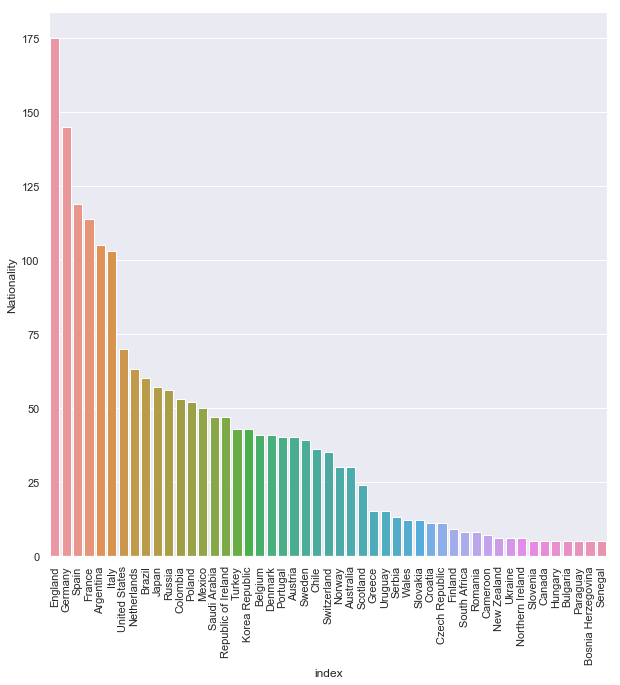

In [122]:
plt.figure(figsize=(10,10))
sns.barplot(x = 'index', y = 'Nationality', data = nt.query('Nationality > 4'))
plt.xticks(rotation = 90)
None